In [5]:
import kagglehub
import os
import logging
from typing import Union, List, Dict, Any
logging.basicConfig(level=logging.INFO)

In [ ]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

In [ ]:
# Predict Online Gaming Behavior Dataset
# https://www.kaggle.com/datasets/rabieelkharoua/predict-online-gaming-behavior-dataset

import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("rabieelkharoua/predict-online-gaming-behavior-dataset")

print("Path to dataset files:", path)

# List the contents of the downloaded directory
#print(os.listdir(path))

Path to dataset files: /Users/aurora/.cache/kagglehub/datasets/rabieelkharoua/predict-online-gaming-behavior-dataset/versions/1


In [8]:
file_name = os.listdir(path)[0]
full_file_path = os.path.join(path, file_name)
full_file_path

'/Users/aurora/.cache/kagglehub/datasets/rabieelkharoua/predict-online-gaming-behavior-dataset/versions/1/online_gaming_behavior_dataset.csv'

In [ ]:
### EDA Util funtions ###

def load_data(file_path: str):
    try:
        df = pd.read_csv(f"{file_path}")
        logging.info("File successfully loaded")
        return df
    
    except Exception as e:
        logging.error(f"Error loading file: {e}")
        return None
    
# def log_transform(series:pd.Series, columns:List[Any]=None)->pd.Series:
#     series = np.log10(series+1)
#     return series  

def log_transform_data(data:pd.DataFrame, columns:List[str], remove_columns:List[str])->pd.DataFrame:
    columns_to_transform = [col for col in columns if columns not in remove_columns]
    log_data = np.log10(data[columns_to_transform]+1)
    log_data.columns = [f'log_{col}' for col in columns]
    
    return log_data

# def make_kde_plots(data:pd.DataFrame, columns:List[str], hue:str=None):
#     fig, axes = plt.subplots(len(columns),1, figsize=(8,12))
#     axes = axes.flatten()

#     for i,col in enumerate(columns):
#         sns.kdeplot(data=data, x=col, fill=True, ax=axes[i], hue=hue)
#     plt.tight_layout()
#     plt.show()

# Plot kde distribution by target
    
def kde_viz_plots(data:pd.DataFrame, columns:List, hue:str='EngagementLevel', cols_to_remove:List[str] = None, common_norm:bool=False):
    if cols_to_remove:
        # Create the final list of columns to plot
        cols_to_plot = [col for col in columns if col not in cols_to_remove]
    else:
        cols_to_plot = columns
    
    n_cols = len(cols_to_plot)
    
    if n_cols == 0:
        print("No columns remaining to plot.")
        return

    fig_height = max(5, n_cols * 3) # Calculate height based on actual plots
    fig, axes = plt.subplots(n_cols, 1, figsize=(15, fig_height))
    
    # Handle the case where only one plot is created (axes is not an array)
    if n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(cols_to_plot):
        sns.kdeplot(data=data, x=col, fill=True, ax=axes[i], hue=hue, common_norm=common_norm)
    
    plt.subplots_adjust(hspace=0.4)
    plt.tight_layout()
    plt.show()

# what is the distribution of the features given the target column categories?

def viz_cat_interaction(data, columns: List[str], target_col:str = 'EngagementLevel'):
    fig_row = len(columns)
    fig,axes = plt.subplots(fig_row, 1, figsize=(8,fig_row*4))
    axes = axes.flatten()

    for i,col in enumerate(columns):
        proportions_df = pd.crosstab(index=data[target_col], columns=data[col], normalize='index').round(4) * 100
        proportions_df.plot(kind='bar', stacked=False, ax=axes[i], rot=0)
    plt.tight_layout()
    plt.show()


# what is the distribution of the target, given the feature column categories?

def vizualize_categorical_interaction(data:pd.DataFrame, feature_cols:List[str], target_col:str = 'EngagementLevel'):
    fig_row = len(feature_cols)
    fig, axes = plt.subplots(fig_row,1, figsize=(8,15))
    axes = axes.flatten()
    
    for i,col in enumerate(feature_cols):
        proportions_df = pd.crosstab(index=data[col], columns=data[target_col], normalize='index')
        proportions_df.plot(kind='bar', stacked=False, ax=axes[i])

    plt.tight_layout()
    plt.show()

def heatmap(data:pd.DataFrame, columns:List[str], target_col:str = 'EngagementLevel'):
    combined_proportions = []
    for col in columns:
        proportions = pd.crosstab(index=data[col], columns=data[target_col], normalize='index').round(3) * 100
        proportions.rename(columns={
            'High':f'{col}_High',
            'Low':f'{col}_Low',
            'Medium':f'{col}_Medium'
        }, inplace=True)
        combined_proportions.append(proportions)
    
    final_df = pd.concat(combined_proportions, axis=0)
    #return final_df
    plt.figure(figsize=(len(columns) * 2, len(final_df) * 0.4))
    sns.heatmap(final_df, annot=True, fmt=".2f", )
    plt.show()  

# Get skewed columns above threshold for log transformation

def skewness_analysis(data:pd.DataFrame, target_col: str = 'EngagementLevel')->pd.DataFrame:
    numerical_cols = data.select_dtypes(include=np.number).columns
    numerical_cols = numerical_cols.drop(target_col, errors='ignore')

    # Calculate skewness for each numerical column
    skew_values = data[numerical_cols].apply(lambda x: skew(x.dropna()))

    # Convert the results to a DataFrame for easy viewing
    skewness_df = pd.DataFrame({
        'Feature': skew_values.index,
        'Skewness': skew_values.values.round(4)
    })

    return skewness_df

# def categorical_to_bool_int(series:pd.Series, values:Union[Any, List[Any]]) -> pd.Series:
    
#     if isinstance(values, List):
#         binary_series = series.isin(values).astype(int)
#     else:
#         binary_series = (series==values).astype(int)

#     if (series==np.nan).any():
#         binary_series = mask(series.isna(), np.nan)
    
#     return binary_series

def categorical_to_ordinal(series:pd.Series, values_from:List[Any]):
    """Converts a categorical series to ordinal"""
    map_dict = {}
    for i,value in enumerate(values_from):
        map_dict[value] = i

    return series.map(map_dict, None)
    
    

In [10]:
df = load_data(file_path=full_file_path)
df.info()

INFO:root:File successfully loaded


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

In [11]:
categorical_columns = df.select_dtypes(include=["object", "category"]).columns.to_list()
numerical_columns =  df.select_dtypes(include=[int, float]).columns.to_list()

In [12]:
df[categorical_columns].head()

,Gender,Location,GameGenre,GameDifficulty,EngagementLevel
0,Male,Other,Strategy,Medium,Medium
1,Female,USA,Strategy,Medium,Medium
2,Female,USA,Sports,Easy,High
3,Male,USA,Action,Easy,Medium
4,Male,Europe,Action,Medium,Medium


In [13]:
df[numerical_columns].head()

,PlayerID,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked
0,9000,43,16.271119,0,6,108,79,25
1,9001,29,5.525961,0,5,144,11,10
2,9002,22,8.223755,0,16,142,35,41
3,9003,35,5.265351,1,9,85,57,47
4,9004,33,15.531945,0,2,131,95,37


In [15]:
print(f"Unique PlayerID: {df['PlayerID'].nunique()}")

Unique PlayerID: 40034


In [16]:
for col in categorical_columns:
    print(f"Column Name: {col}")
    print(df[col].value_counts())
    print('--------------------')

Column Name: Gender
Gender
Male      23959
Female    16075
Name: count, dtype: int64
--------------------
Column Name: Location
Location
USA       16000
Europe    12004
Asia       8095
Other      3935
Name: count, dtype: int64
--------------------
Column Name: GameGenre
GameGenre
Sports        8048
Action        8039
Strategy      8012
Simulation    7983
RPG           7952
Name: count, dtype: int64
--------------------
Column Name: GameDifficulty
GameDifficulty
Easy      20015
Medium    12011
Hard       8008
Name: count, dtype: int64
--------------------
Column Name: EngagementLevel
EngagementLevel
Medium    19374
High      10336
Low       10324
Name: count, dtype: int64
--------------------


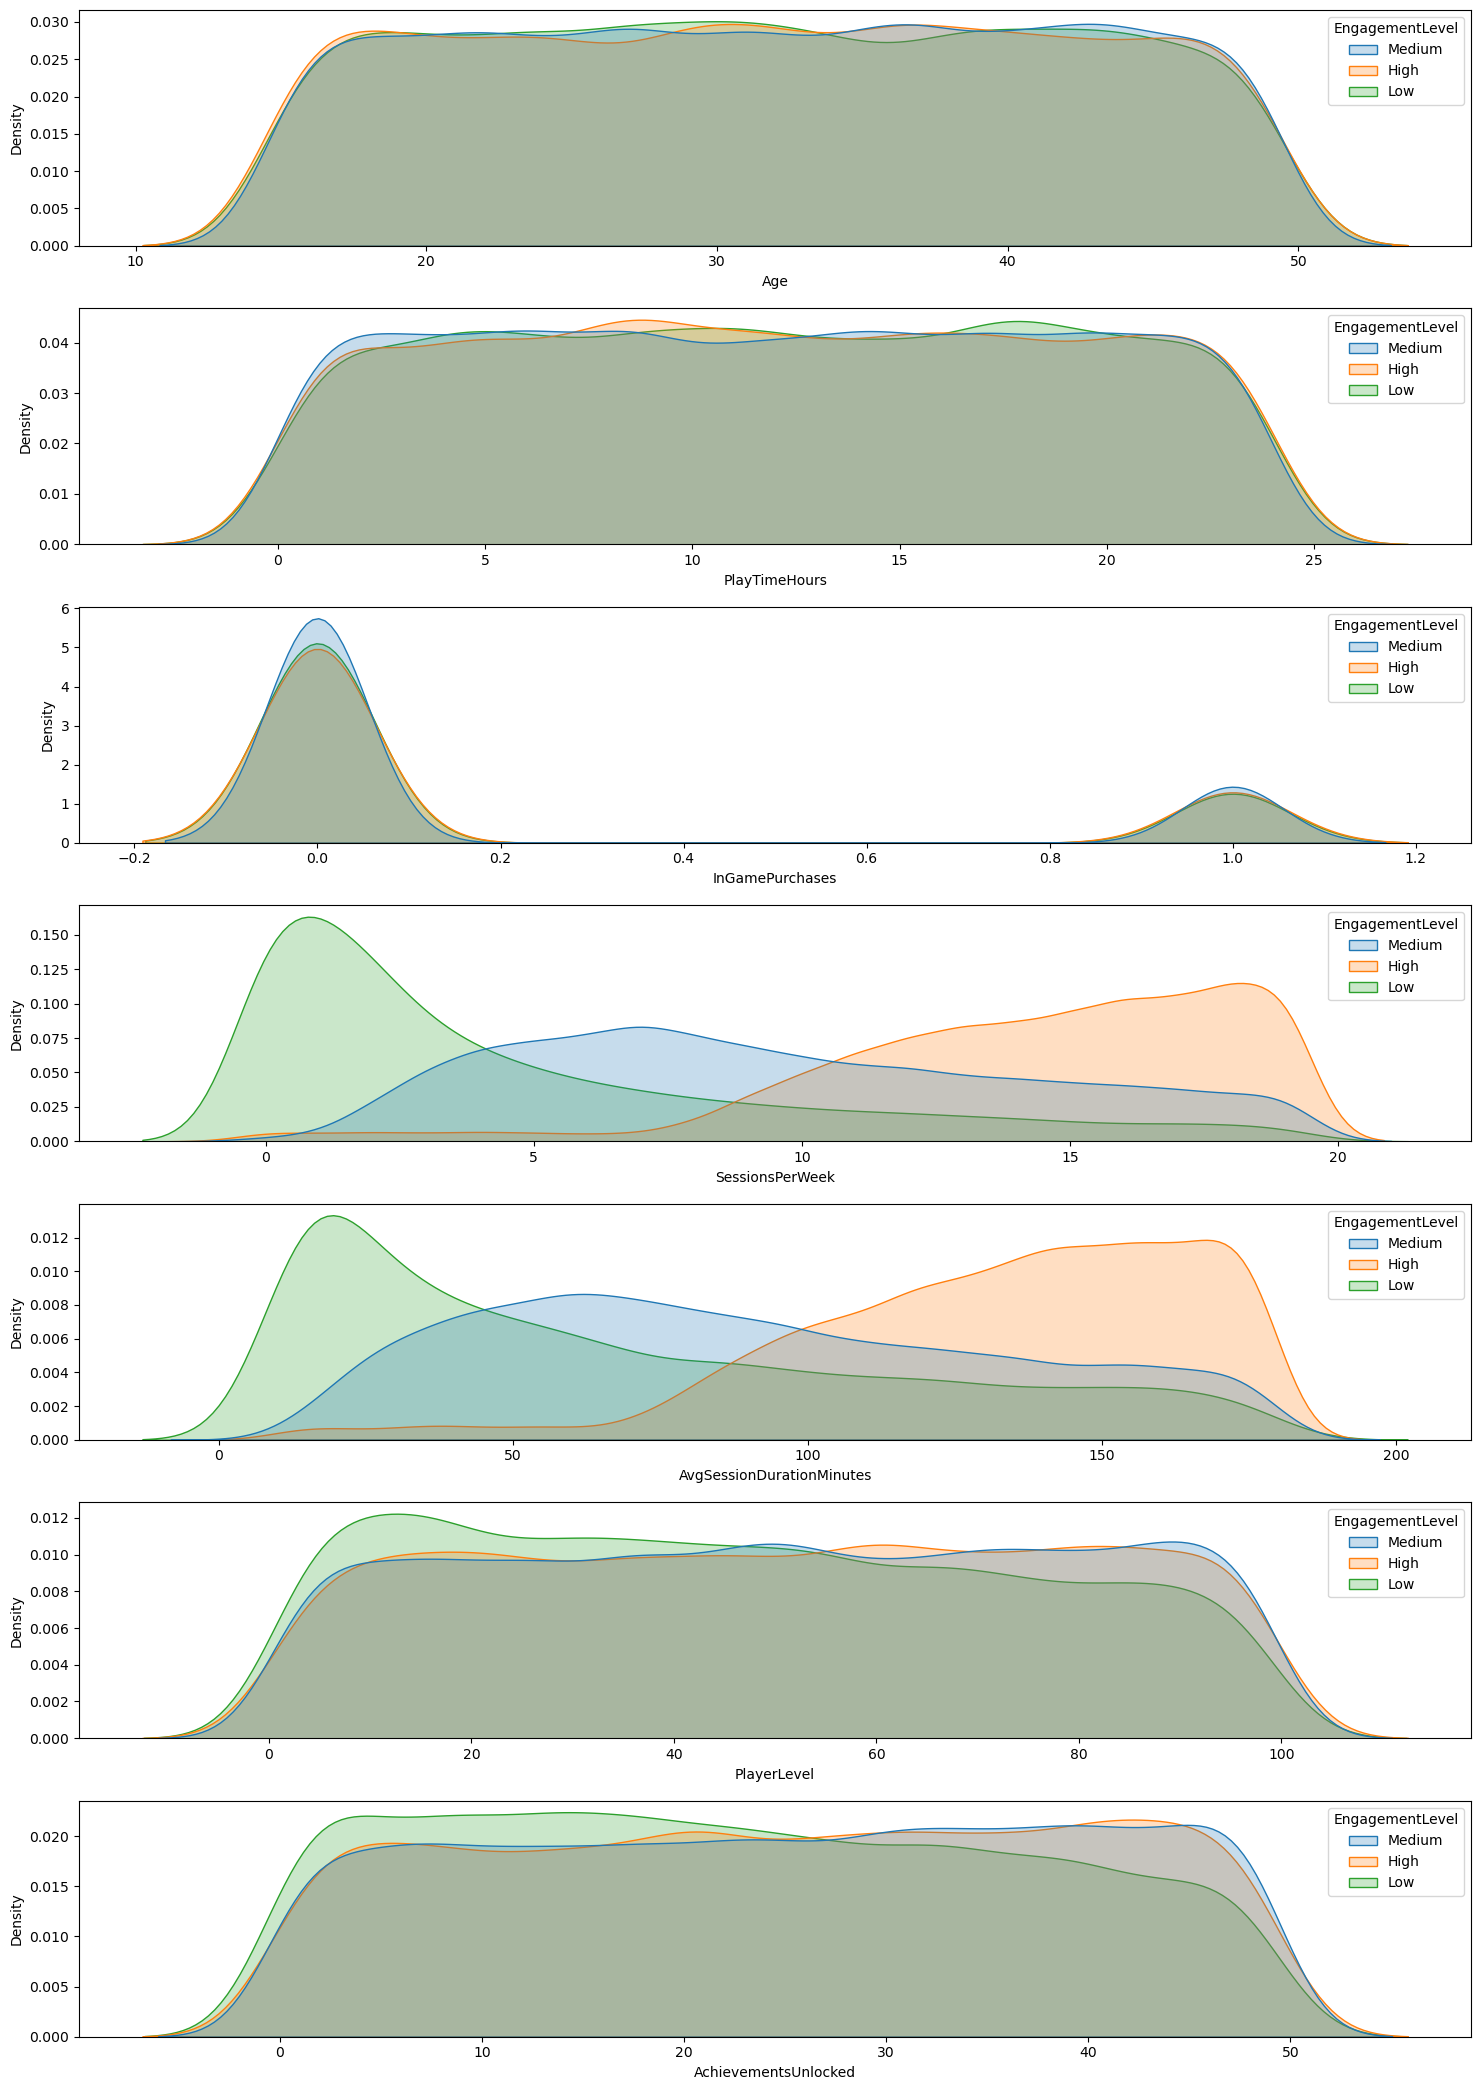

In [46]:
kde_viz_plots(data=df, columns=numerical_columns, hue='EngagementLevel', cols_to_remove=['EngagementLevel', 'PlayerID'])

In [ ]:
# SessionsPerWeek and AvgSessionTime are highly correlated to EngagemetLevel. 
# Depending on when EngagementLevel is assigned, these two features may leak information about the target which would be cause for removal.

<Axes: >

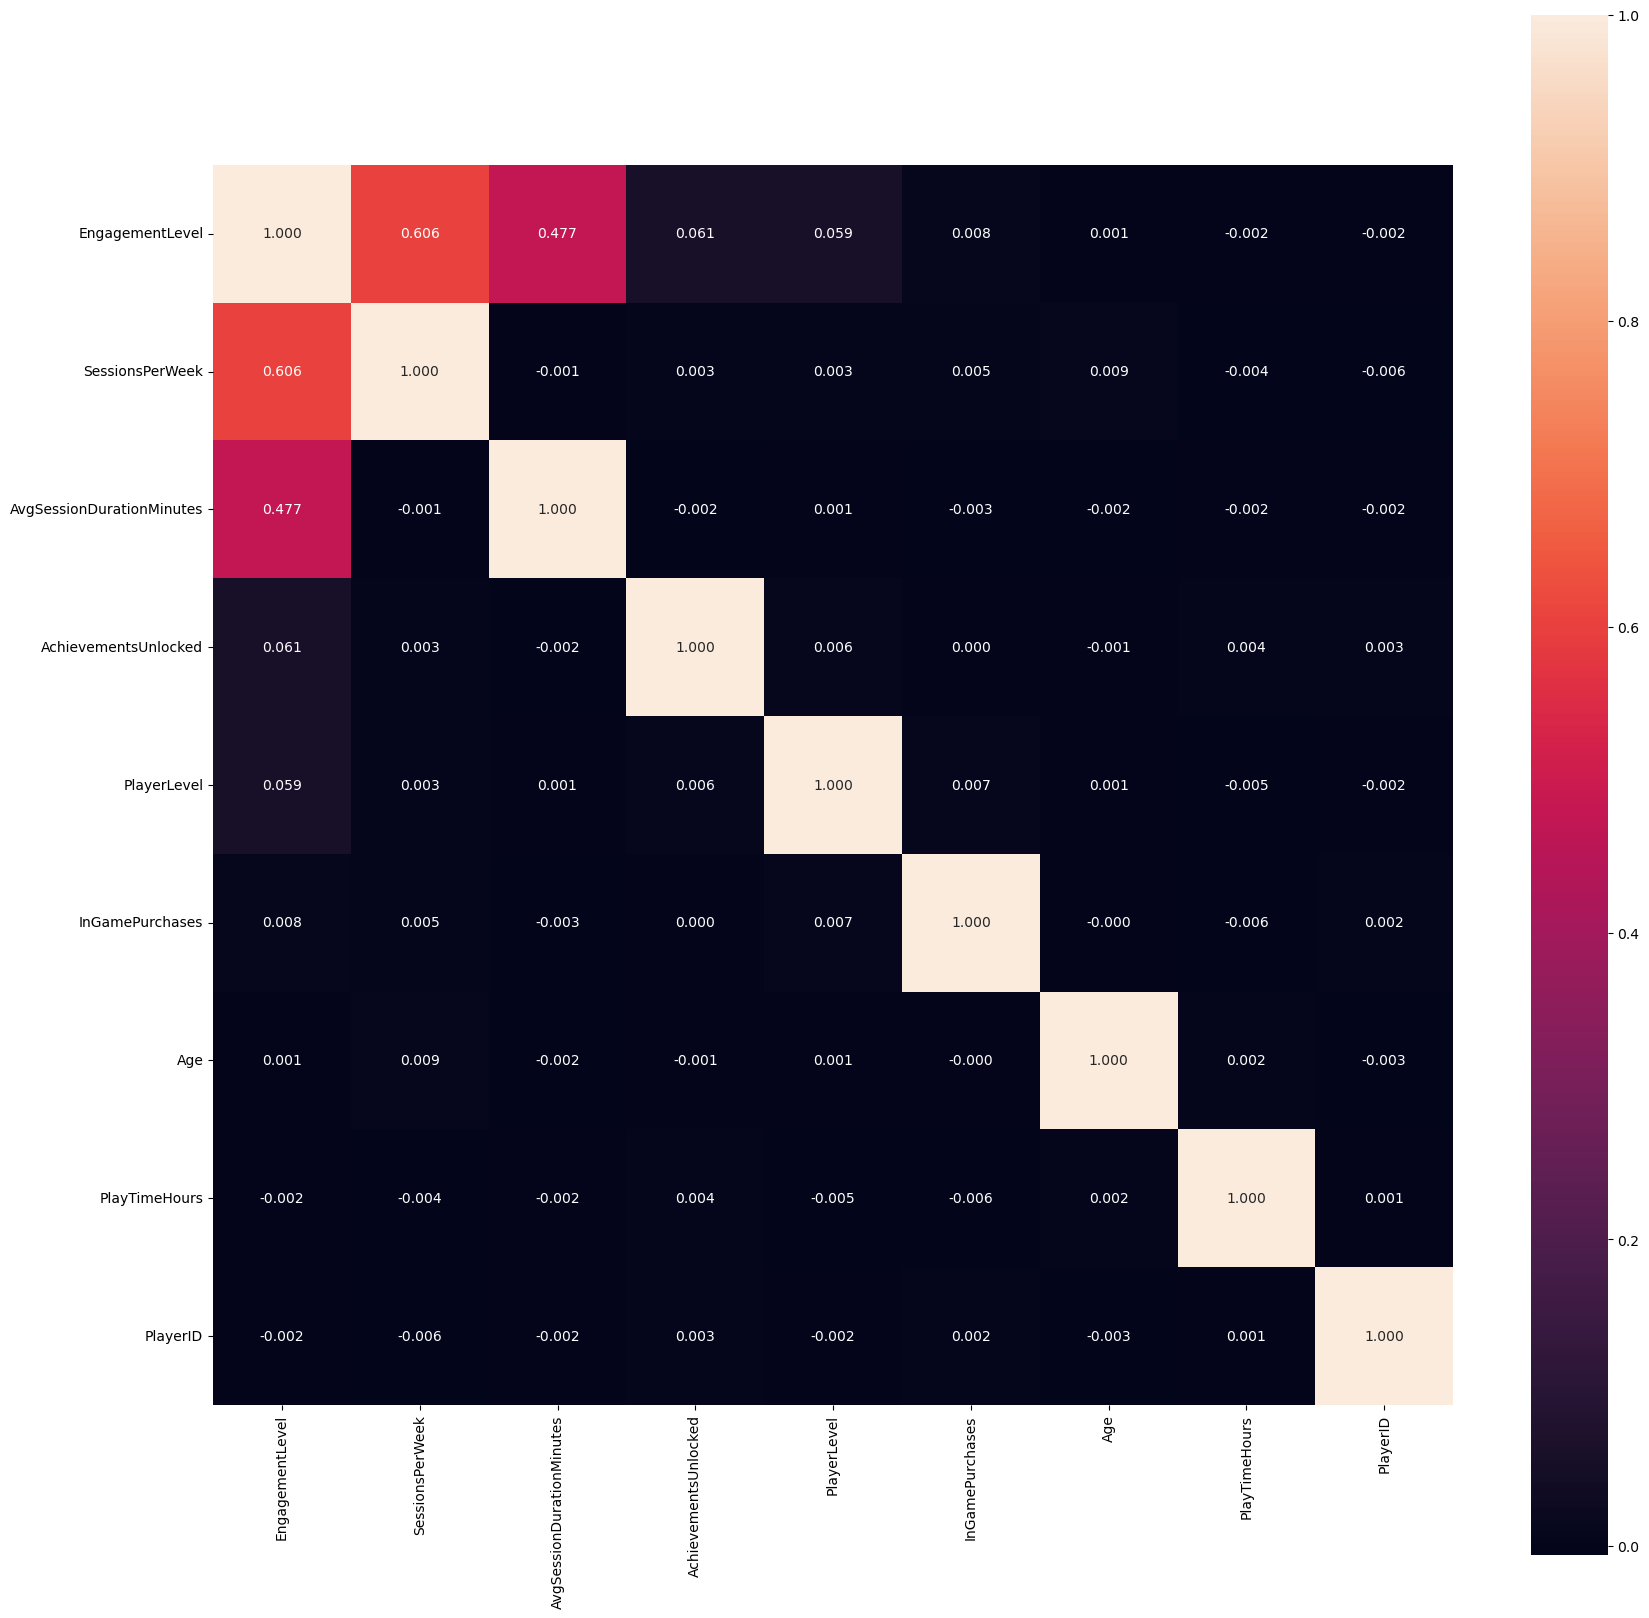

In [ ]:
# correlations

corr_df = df[numerical_columns]
corr_df['EngagementLevel'] = categorical_to_ordinal(df['EngagementLevel'], values_from=['Low', 'Medium', 'High'])

corrmat = corr_df.corr()
k = len(corr_df.columns)
cols = corrmat.nlargest(k, 'EngagementLevel')['EngagementLevel'].index
cm = np.corrcoef(corr_df[cols].values.T)

f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm,cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [28]:
skewness_df = skewness_analysis(df)

# Filter for columns that are highly right-skewed (positive skew)
# A common threshold for 'high skew' is a value > 1.0 or > 0.8

right_skewed_cols = skewness_df[skewness_df['Skewness'] > 0.7].sort_values(
    by='Skewness', ascending=False
)

# Display the columns
print("Highly Right-Skewed Columns (Candidates for Log Transformation):")
print(right_skewed_cols)

Highly Right-Skewed Columns (Candidates for Log Transformation):
           Feature  Skewness
3  InGamePurchases    1.4933


In [29]:
df[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
PlayerID,40034.0,29016.500000,11556.964675,9000.000000,19008.250000,29016.500000,39024.750000,49033.000000
Age,40034.0,31.992531,10.043227,15.000000,23.000000,32.000000,41.000000,49.000000
PlayTimeHours,40034.0,12.024365,6.914638,0.000115,6.067501,12.008002,17.963831,23.999592
InGamePurchases,40034.0,0.200854,0.400644,0.000000,0.000000,0.000000,0.000000,1.000000
SessionsPerWeek,40034.0,9.471774,5.763667,0.000000,4.000000,9.000000,14.000000,19.000000
AvgSessionDurationMinutes,40034.0,94.792252,49.011375,10.000000,52.000000,95.000000,137.000000,179.000000
PlayerLevel,40034.0,49.655568,28.588379,1.000000,25.000000,49.000000,74.000000,99.000000
AchievementsUnlocked,40034.0,24.526477,14.430726,0.000000,12.000000,25.000000,37.000000,49.000000


In [30]:
df_log_tsfrm = log_transform_data(data=df, columns=right_skewed_cols.Feature.to_list(), remove_columns=['EngagementLevel'])
df_log_tsfrm['EngagementLevel'] = df['EngagementLevel']

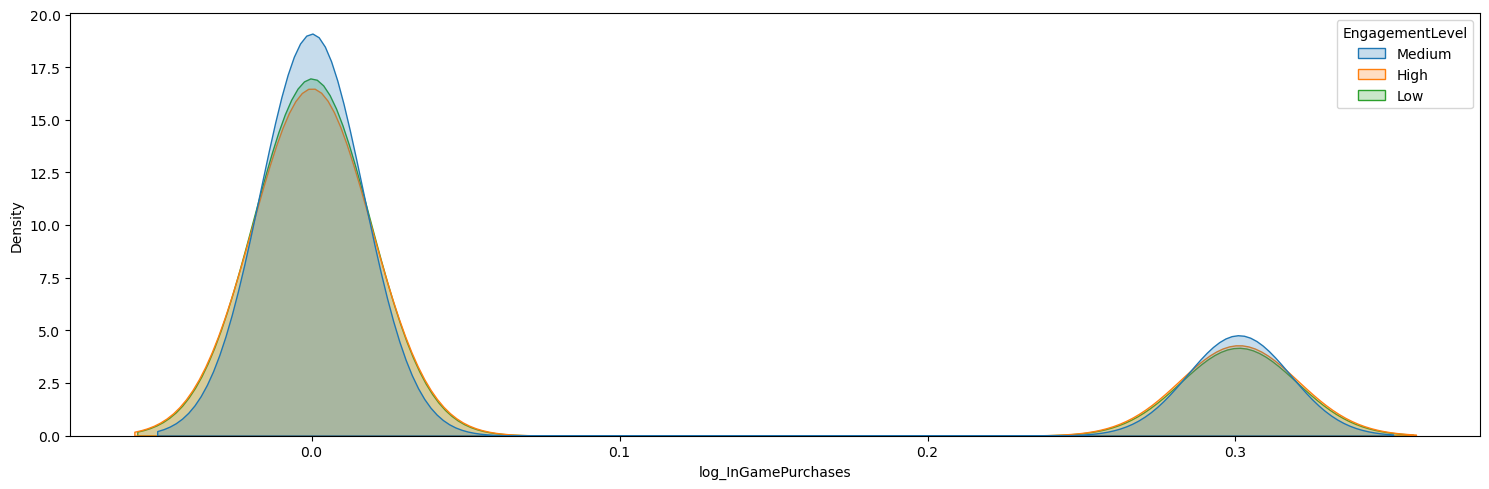

In [47]:
kde_viz_plots(df_log_tsfrm, columns=df_log_tsfrm.columns, common_norm=False, hue='EngagementLevel', cols_to_remove=['EngagementLevel'])

['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']


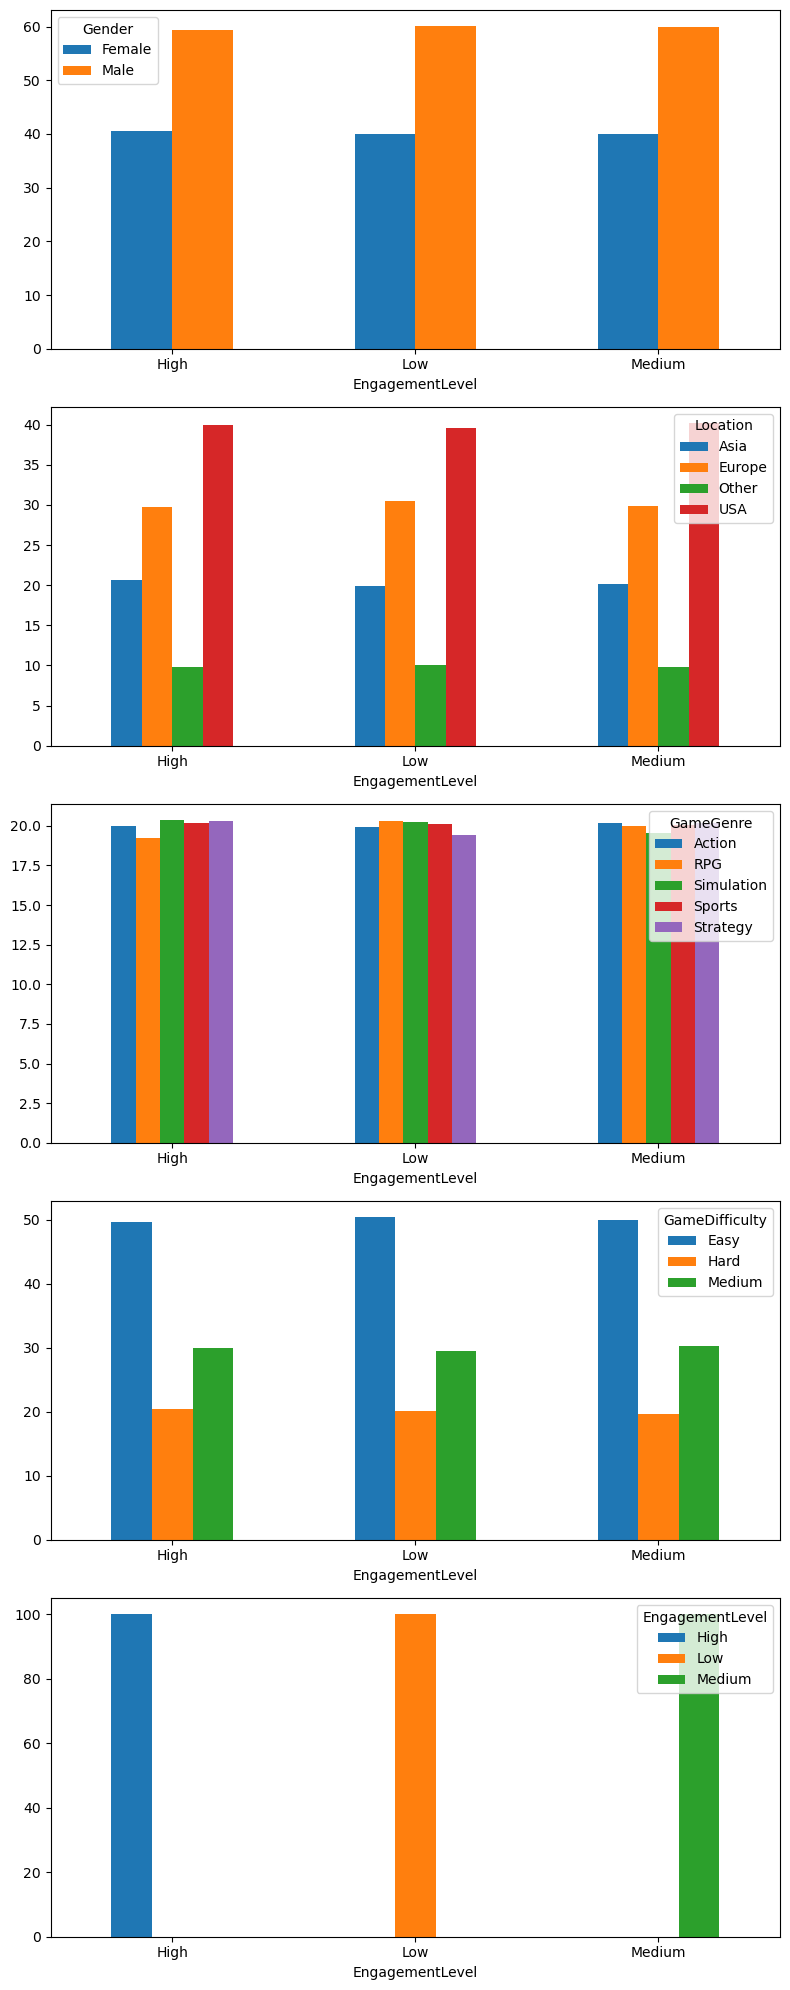

In [18]:
print(categorical_columns)
viz_cat_interaction(df, columns=categorical_columns)

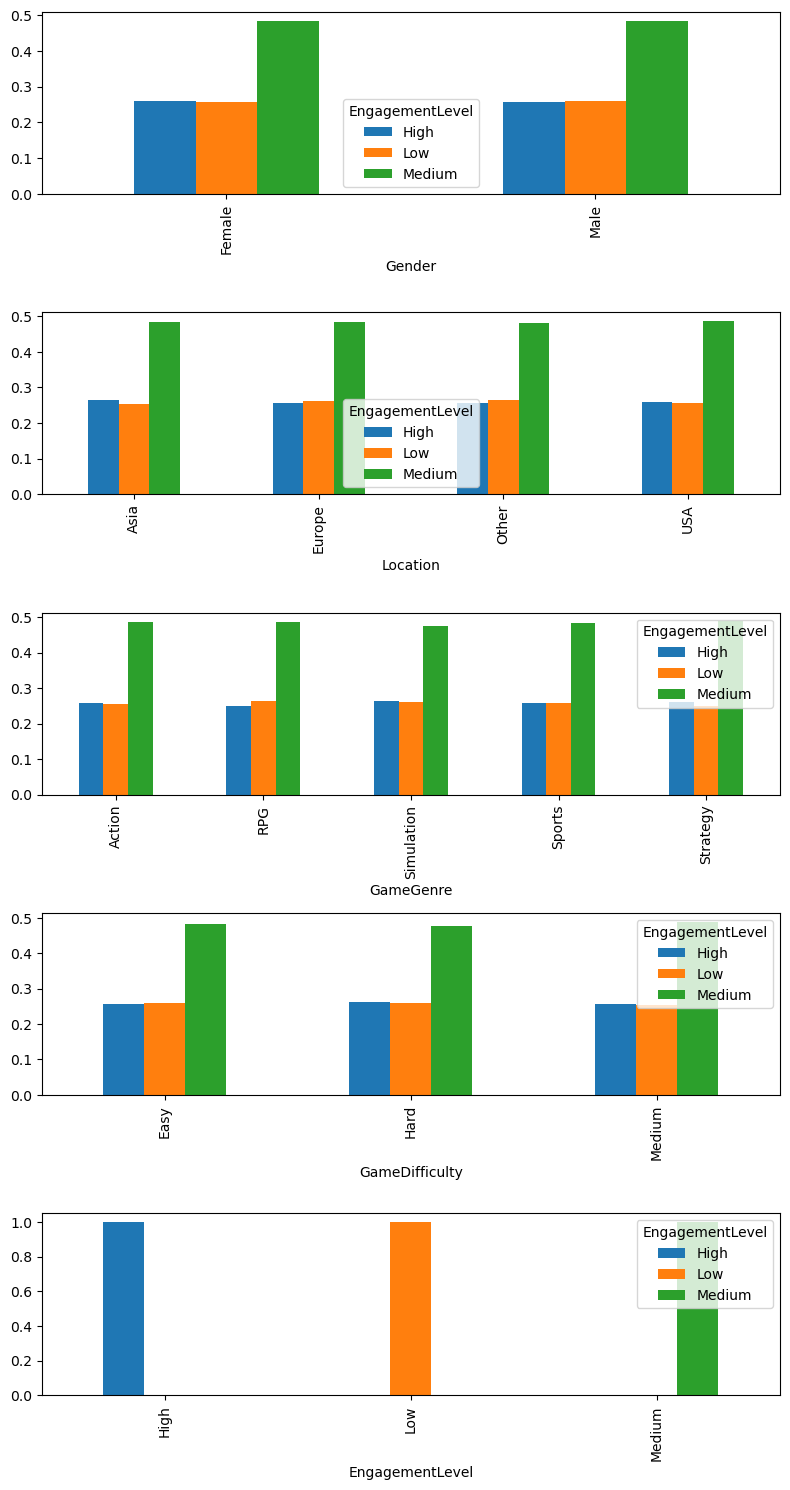

In [ ]:
vizualize_categorical_interaction(df, feature_cols=categorical_columns)

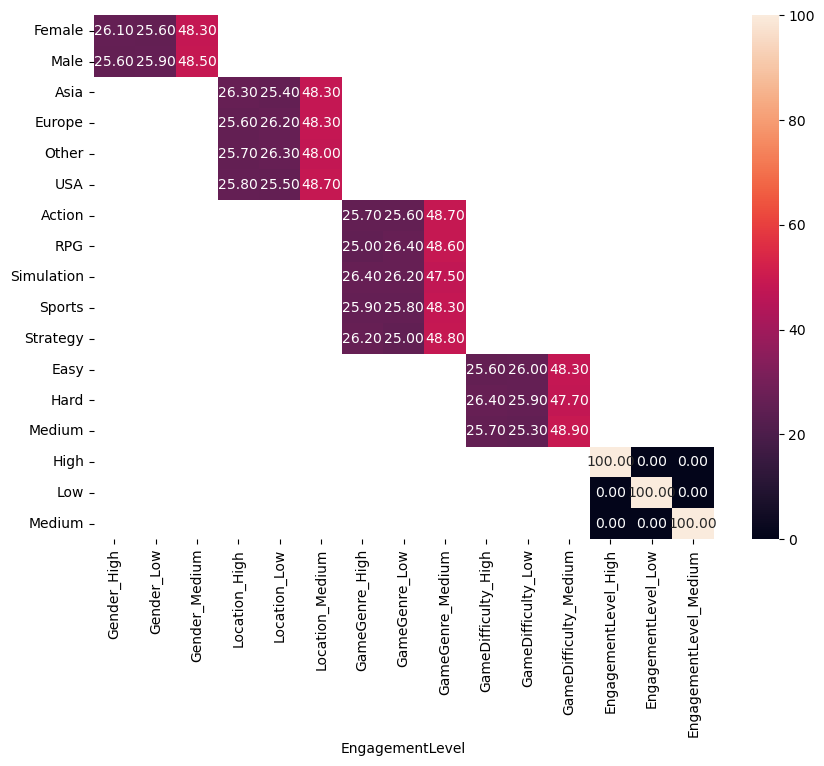

In [24]:
heatmap(df, categorical_columns)

In [ ]:
# # Interaction Features

# # Average duration per session: PlayTimeHours / SessionsPerWeek
# df['Global_Duration'] = interaction_features(series_numerator= df['PlayTimeHours'], series_denominator=df['SessionsPerWeek'])

# # Achievements per hr (an indication of skill level): AchievementsUnlocked / PlayTimeHours
# df['AchievementsUnlocked_hr'] = interaction_features(series_numerator= df['AchievementsUnlocked'], series_denominator=df['PlayTimeHours'])

# # Age * InGamePurchases
# df['Purchasers_Age'] = df['Age']*df['InGamePurchases']

# # Bin PlayerLevelx
# df['PlayerLevel_bins'] = pd.cut(df['PlayerLevel'], bins=bins, labels=labels, right=False)

# # How advanced a player is according to their age: PlayerLevel / Age
# df['PlayerLevel_Age'] = interaction_features(series_numerator= df['PlayerLevel'], series_denominator=df['Age'])

# # How advanced a player is according to their dedication to play: PlayerLevel / PlayTimeHours
# df['PlayerLevel_PlayTimeHours'] = interaction_features(series_numerator= df['PlayerLevel'], series_denominator=df['PlayTimeHours'])


In [ ]:
## Util Functions START ##

def categorical_to_ordinal(series:pd.Series, values_from:List[Any]):
    """Converts a categorical series to ordinal"""
    map_dict = {}
    for i,value in enumerate(values_from):
        map_dict[value] = i

    return series.map(map_dict, None)
    
def interaction_features(series_numerator: pd.Series, series_denominator: pd.Series) -> pd.Series:
    """
    Uses devision to create an interaction between two continuous columns (pd.Series)

    Args:

    Returs:
        Series that is the devision of the two input series
    """
    if (series_denominator==0).any():
        series_denominator = series_denominator.mask(series_denominator==0, np.nan)
    return series_numerator/series_denominator

def safe_log_transform(series:pd.Series):
    return np.log10(series+1)

def calculate_binary_metrics(X, y_true, model, average: str ='weighted')->Dict[str, str]:
    """Utility to compute predictions and metrics for a given dataset."""
    if X is None or y_true is None:
        return {"Error": "Data not available"}
    
    if not hasattr(model, 'predict_proba'):
        logging.error("Model does not support predict_proba.")
        return {"Error": "No predict_proba method"}
    
    try:
        y_proba = model.predict_proba(X)
        y_pred = model.predict(X)

        # Use average='binary' for the positive class (index 1)
        # Use 'weighted' average for Precision/Recall/F1 for imbalanced multi-class data
        avg_precision = precision_score(y_true, y_pred, average=average, zero_division=0)
        avg_recall = recall_score(y_true, y_pred, average=average, zero_division=0)
        avg_f1 = f1_score(y_true, y_pred, average=, zero_division=0)
        
        # Select probability of the positive class (index 1) for binary AUROC
        # positive_class_proba = y_proba[:, 1] 
        # auroc = roc_auc_score(y_true, positive_class_proba)
        auroc = roc_auc_score(y_true, y_proba, multi_class='ovo', average='weighted')
        
        return {
            'Precision': f"{avg_precision:.4f}",
            'Recall': f"{avg_recall:.4f}",
            'F1': f"{avg_f1:.4f}",
            'AUROC': f"{auroc:.4f}"
        }
    except Exception as e:
        logging.error(f"Error calculating metrics: {e}")
        return {"Error": "Calculation Failed"}

## Util Functions END ##

In [77]:

class Preprocessing:
    def __init__(self, file_path:str, sample_size:int=10000, random_state:int=42):
        self.file_path = file_path
        self.data = None
        self.sample_size = sample_size
        self.random_state = random_state

    def load_data(self):
        try:
            self.data = pd.read_csv(f"{self.file_path}")
            logging.info("File successfully loaded")
            return self.data
        
        except Exception as e:
            logging.error(f"Error loading file: {e}")
            return None

    def preprocess_features(self):
        if self.data is None:
            logging.error("Dataset was not properly loaded. Run load_data() first")
            return None
            
        logging.info("Preprocessing features...")
        # Average duration per session: PlayTimeHours / SessionsPerWeek
        self.data['Global_Duration'] = interaction_features(series_numerator=self.data['PlayTimeHours'], series_denominator=self.data['SessionsPerWeek'])
        
        # Achievements per hr (an indication of skill level): AchievementsUnlocked / PlayTimeHours
        self.data['AchievementsUnlocked_hr'] = interaction_features(series_numerator= self.data['AchievementsUnlocked'], series_denominator=self.data['PlayTimeHours'])
        
        # Age * InGamePurchases
        self.data['Purchasers_Age'] = self.data['Age']*self.data['InGamePurchases']
        
        # Bin PlayerLevelx
        #self.data['PlayerLevel_bins'] = pd.cut(self.data['PlayerLevel'], bins=bins, labels=labels, right=False)
        
        # How advanced a player is according to their age: PlayerLevel / Age
        self.data['PlayerLevel_Age'] = interaction_features(series_numerator= self.data['PlayerLevel'], series_denominator=self.data['Age'])
        
        # How advanced a player is according to their dedication to play: PlayerLevel / PlayTimeHours
        self.data['PlayerLevel_PlayTimeHours'] = interaction_features(series_numerator= self.data['PlayerLevel'], series_denominator=self.data['PlayTimeHours'])

        logging.info("Preprocessing target...")
        
        self.data['EngagementLevel'] = categorical_to_ordinal(self.data['EngagementLevel'], values_from=['Low', 'Medium', 'High'])
        
        logging.info("Dataset successfully preprocessed!")

    def sample_data(self):
        if self.data is not None:
            self.data = self.data.sample(n=self.sample_size, random_state=self.random_state)
            logging.info(f"Data successfully subsampled to {self.sample_size} records.")
        else:
            logging.warning("Data not loaded. Please load data before sampling.")

    def run_preprocessing_pipeline(self):
        self.load_data()

        if self.data is None:
            return None
        
        if self.sample_size is not None:
            self.sample_data()

        self.preprocess_features()

        return self
        

In [101]:

# create the feature engineering pipeline

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import logging
import pickle
from numpy import sqrt, argmax
from typing import List, Any
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
# New Imports for comprehensive evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

EXPERIMENT_ID = 0


class ModelBuild:
    def __init__(self, preprocessed_data:pd.DataFrame, target_col:str, ID_col: str, log_features: List[str] = None, model_type: str = 'GBC'):
        self.data = preprocessed_data
        self.target_col = target_col
        self.ID_col = ID_col
        self.log_features = log_features if log_features is not None else []
        self.model_type = model_type.upper()

        self.timestamp = None

        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.ID_test = None # this can be used for the model QA
        #self.ID_train = None
        self.best_estimator = None

        if self.model_type not in ['GBC', 'LR']:
            raise ValueError("model_type must be 'GBC' for GradientBoostingClassifier or 'LR' for LogisticRegression.")
        
    def split_data(self):
        if self.data is None:
            logging.error("Data not loaded.")
            return None
        
        X = self.data.drop(columns=[self.target_col, self.ID_col])
        y = self.data[self.target_col]
        ID = self.data[self.ID_col]

        if y.dtype not in ['int64', 'float64']:
            y = categorical_to_ordinal(y, values_from=['Low', 'Medium', 'High'])
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, stratify=y, random_state=42)

        self.ID_test = ID.loc[self.X_test.index]
        #self.ID_train = ID.loc[self.X_train.index]

    def transform_data(self):
        if self.X_train is None:
            logging.error("Data must be split before fitting.")
            return
            
        all_numerical = self.X_train.select_dtypes(include=[np.number]).columns.to_list()  
        categorical_features = self.X_train.select_dtypes(include=['category', 'object']).columns.to_list()

        # ----------------------------------------------------
        # Logging Categorical Features
        logging.info(f"Categorical Features ({len(categorical_features)}): {categorical_features}")
        # ----------------------------------------------------

        binary_features = []

        for col in all_numerical:
            if set(self.X_train[col]).issubset({0,1}):
                binary_features.append(col)
        
        numerical_features = [col for col in all_numerical if col not in binary_features + self.log_features]

        # ----------------------------------------------------
        # Logging Remaining Feature Types
        logging.info(f"Numerical Features ({len(numerical_features)}): {numerical_features}")
        logging.info(f"Log-Transformed Features ({len(self.log_features)}): {self.log_features}")
        logging.info(f"Binary (0/1) Features ({len(binary_features)}): {binary_features}")
        # ----------------------------------------------------

        # Transformer Definitions
        categorical_transformer = ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing_cat')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        numerical_transformer = ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=-9999)),
            ('std_scaler', StandardScaler())
        ])

        binary_transformer =  ImbPipeline(steps = [
            ('imputer', SimpleImputer(strategy='constant', fill_value=0))
        ])

        log_transformer = ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=-9999)),
            ('log', FunctionTransformer(safe_log_transform, feature_names_out='one-to-one')),
            ('std_scaler', StandardScaler())
        ])

        # Column Transformer (Preprocessor)
        transformers = [
            ('categorical', categorical_transformer, categorical_features)
        ]

        if numerical_features:
            transformers.append(('num', numerical_transformer, numerical_features))
        
        if binary_features:
            transformers.append(('binary', binary_transformer, binary_features))

        if self.log_features:
            transformers.append(('log', log_transformer, self.log_features))

        preprocessor = ColumnTransformer(
            transformers = transformers,
            remainder = 'drop'
        )

        smote_params = {
            'smote_tomek__sampling_strategy': [
            # Strategy 1: Moderate increase (12k and 14k)
            {0: 12000, 1: 19374, 2: 14000}, 
            
            # Strategy 2: Higher increase (16k and 16k)
            {0: 16000, 1: 19374, 2: 16000},
            
            # # Strategy 3: Perfect balance (19374 for all)
            # {0: 19374, 1: 19374, 2: 19374} 
            ],
        }

        # Pipeline grid

        if self.model_type == 'GBC':
            # GBC Pipeline & Grid
            estimator = GradientBoostingClassifier(random_state=42, subsample=0.80, max_features='sqrt')
            pipeline = ImbPipeline(steps=[
                ('preprocessor', preprocessor),
                ('smote_tomek', SMOTETomek(random_state=42)),
                ('GBC', estimator)
            ])
            param_grid = {
                **smote_params,
                'GBC__n_estimators': [50, 100, 200],
                'GBC__max_depth': [2, 3, 4], # Regularized depth
                'GBC__min_samples_leaf': [20, 50, 100], # Regularized leaf size
                'GBC__learning_rate': [0.01, 0.1]
            }
            logging.info("Building Gradient Boosting Classifier (GBC) model.")
            
        elif self.model_type == 'LR':
            # LR Pipeline & Grid
            estimator = LogisticRegression(random_state=42, solver='saga', max_iter=5000) # Use saga for L1/L2 and large data
            pipeline = ImbPipeline(steps=[
                ('preprocessor', preprocessor),
                ('smote_tomek', SMOTETomek(random_state=42)),
                ('LR', estimator)
            ])
            param_grid = {
                **smote_params,
                'LR__C': [0.01, 0.1, 1.0, 10.0], # Inverse regularization strength
                'LR__penalty': ['l1', 'l2', 'elasticnet'],
                'LR__l1_ratio': [0.1, 0.5, 0.9] if 'elasticnet' in ['l1', 'l2', 'elasticnet'] else [None] # For elasticnet
            }
            logging.info("Building Logistic Regression (LR) model.")

        # Randomized Search
        stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        random_search = RandomizedSearchCV(estimator=pipeline, 
                                  param_distributions=param_grid, 
                                  n_iter=10,
                                  scoring='f1_weighted', 
                                  cv=stratified_cv, 
                                  n_jobs=-1, 
                                  random_state=42,
                                  verbose=2)
        
        random_search.fit(self.X_train, self.y_train)

        logging.info(f"Best cross-validation score: {random_search.best_score_}")
        logging.info(f"Best parameters: {random_search.best_params_}")
        
        self.best_estimator = random_search.best_estimator_

    def evaluate_model(self):
        """
        Calculates and prints avg precision, avg recall, and AUROC 
        for both the training and testing sets.
        """
        if self.best_estimator is None:
            logging.error("Model must be trained before evaluation. Run run_model_pipeline() first.")
            return

        logging.info("\n--- MODEL EVALUATION (TRAIN & TEST) ---")

        sets = {
            'Train': (self.X_train, self.y_train),
            'Test (Unseen)': (self.X_test, self.y_test)
        }

        # 2. Metric Calculation Loop: Use the imported utility function
        results = {}
        for name, (X_data, y_true) in sets.items():
            logging.info(f"Calculating metrics for {name} set...")
            results[name] = calculate_binary_metrics(
                X=X_data, 
                y_true=y_true, 
                model=self.best_estimator
            )
        
        # 3. Output Results (Adjusted to match the utility function's output keys)
        print("\n--- PERFORMANCE SUMMARY ---")
        for name, metrics in results.items():
            print(f"\n{name} Set:")
            if isinstance(metrics, dict) and "Error" not in metrics:
                # Keys are now simply 'Precision', 'Recall', 'F1', 'AUROC'
                print(f"  {'Precision':<25}: {metrics.get('Precision')}")
                print(f"  {'Recall':<25}: {metrics.get('Recall')}")
                print(f"  {'F1':<25}: {metrics.get('F1')}")
                print(f"  {'AUROC':<25}: {metrics.get('AUROC')}")
            else:
                print(f"  {metrics.get('Error', 'Calculation Failed')}")
        print("---------------------------\n")

        return results

    def save_results_json(self, results_dict: dict, filename: str = 'model_metrics.json'):
        """Saves the evaluation results dictionary to a local JSON file."""
        try:
            with open(filename, 'w') as f:
                # Use indent=4 for human-readable formatting
                json.dump(results_dict, f, indent=4)
            logging.info(f"Evaluation metrics successfully saved to {filename}")
        except Exception as e:
            logging.error(f"Failed to save JSON file: {e}")

    def save_model_artifact(self, filename: str = 'full_model_artifact.pkl'):
        """Saves the fitted model pipeline AND the test data needed for QA in one file."""
        if self.best_estimator is None or self.X_test is None:
            logging.error("Cannot save artifact: Model or test data is missing.")
            return

        # Bundle everything into a single dictionary
        full_artifact = {
            'model': self.best_estimator,
            # 'X_train': self.X_train, # Added train data for ModelQA to use if needed
            # 'y_train': self.y_train, # Added train data for ModelQA to use if needed
            'X_test': self.X_test,
            'y_test': self.y_test,
            'ID_test': self.ID_test
        }
        
        try:
            with open(filename, 'wb') as f:
                # Pickle the entire dictionary
                pickle.dump(full_artifact, f, protocol=4)
            logging.info(f"Full model artifact successfully saved to {filename}")
        except Exception as e:
            logging.error(f"Failed to save model artifact file: {e}")

    def run_model_pipeline(self):
        """
        Primary method to execute the entire modeling process: 
        splits data, fits the model, evaluates performance, and saves results/model.
        
        Returns: The best fitted model pipeline (self.best_estimator).
        """
        logging.info("--- Starting Model QA Pipeline ---")

        # Increment the class-level ID for this run
        global EXPERIMENT_ID
        EXPERIMENT_ID += 1
        self.current_experiment_id = EXPERIMENT_ID
        self.timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        run_prefix = f"Exp{self.current_experiment_id:03d}_{self.timestamp}"
        logging.info(f"Current Experiment ID: {self.current_experiment_id} | Timestamp: {self.timestamp}")

        self.split_data()
        
        if self.X_train is None:
            logging.error("Pipeline aborted: Data split failed.")
            return None
        
        # FIT MODEL (Grid Search)
        self.transform_data()
        
        if self.best_estimator is None:
            logging.error("Pipeline aborted: Model fitting failed.")
            return None
        
        # EVALUATE MODEL
        logging.info("Starting model evaluation...")
        results_dict = self.evaluate_model()
        
        # SAVE RESULTS AND MODEL
        if results_dict:
            # Save evaluation metrics to JSON
            self.save_results_json(
                results_dict=results_dict, 
                filename=f'{run_prefix}_metrics.json'
            )
        
        # Save the best fitted pipeline
        self.save_model_artifact(
            filename=f'{run_prefix}_artifact.pkl'
        )
        
        logging.info("--- Model QA Pipeline Complete ---")
        
        return self.best_estimator

In [86]:
file_name = os.listdir(path)[0]
full_file_path = os.path.join(path, file_name)
feature_preprocessing = Preprocessing(file_path=full_file_path, sample_size=None)
pipeline = feature_preprocessing.run_preprocessing_pipeline()
preprocessed_data = pipeline.data

preprocessed_data.EngagementLevel.value_counts(normalize=True, dropna=False)

INFO:root:File successfully loaded
INFO:root:Preprocessing features...
INFO:root:Preprocessing target...
INFO:root:Dataset successfully preprocessed!


EngagementLevel
1    0.483939
2    0.258181
0    0.257881
Name: proportion, dtype: float64

In [93]:
skewness_df = skewness_analysis(preprocessed_data)

# Filter for columns that are highly right-skewed (positive skew)
# A common threshold for 'high skew' is a value > 1.0 or > 0.8
right_skewed_cols = skewness_df[skewness_df['Skewness'] > 0.7].sort_values(
    by='Skewness', ascending=False
)

# Display the columns
print("Highly Right-Skewed Columns (Candidates for Log Transformation):")
print(right_skewed_cols)

Highly Right-Skewed Columns (Candidates for Log Transformation):
                      Feature  Skewness
12  PlayerLevel_PlayTimeHours  176.7695
9     AchievementsUnlocked_hr  131.1403
8             Global_Duration    3.5798
10             Purchasers_Age    1.8726
3             InGamePurchases    1.4933
11            PlayerLevel_Age    0.9831


In [94]:
EXPERIMENT_ID = 0 

In [ ]:
# outcome features to be removed
# These features are the final, summarized result of the match state, often used by the system itself to determine the final outcome or reward. 
# They are too close to the "proof" of the engagement event, rather than the behavior leading up to it.

outcome_features = ['SessionsPerWeek', 'AvgSessionTime']

In [ ]:


log_features_list = [
    'PlayerLevel_PlayTimeHours', 'AchievementsUnlocked_hr', 'Global_Duration', 'Purchasers_Age', 'InGamePurchases', 'PlayerLevel_Age'
 ]

#drop_columns = outcome_features
model_build = ModelBuild(#preprocessed_data=preprocessed_data.drop(columns=drop_columns), 
                           preprocessed_data=preprocessed_data, 
                           target_col='EngagementLevel', 
                           ID_col='PlayerID', 
                           #log_features=log_features_list, 
                           model_type='LR'
                           )
model_build.run_model_pipeline();
print("Model run complete. Check log/files for results.")


INFO:root:--- Starting Model QA Pipeline ---
INFO:root:Current Experiment ID: 1 | Timestamp: 20251031_080046
INFO:root:Categorical Features (4): ['Gender', 'Location', 'GameGenre', 'GameDifficulty']
INFO:root:Numerical Features (11): ['Age', 'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked', 'Global_Duration', 'AchievementsUnlocked_hr', 'Purchasers_Age', 'PlayerLevel_Age', 'PlayerLevel_PlayTimeHours']
INFO:root:Log-Transformed Features (0): []
INFO:root:Binary (0/1) Features (1): ['InGamePurchases']
INFO:root:Building Logistic Regression (LR) model.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/miniconda3/envs/kaggle_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/kaggle_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/kaggle_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/kaggle_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/kaggle_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty i

[CV] END LR__C=10.0, LR__l1_ratio=0.5, LR__penalty=l2, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time=  56.9s
[CV] END LR__C=10.0, LR__l1_ratio=0.5, LR__penalty=l2, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time=  58.2s
[CV] END LR__C=10.0, LR__l1_ratio=0.5, LR__penalty=l2, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time=  59.3s
[CV] END LR__C=10.0, LR__l1_ratio=0.5, LR__penalty=l2, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.1min
[CV] END LR__C=0.01, LR__l1_ratio=0.1, LR__penalty=l1, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.1min
[CV] END LR__C=10.0, LR__l1_ratio=0.5, LR__penalty=l2, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.1min


/opt/miniconda3/envs/kaggle_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/kaggle_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/kaggle_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/kaggle_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END LR__C=0.01, LR__l1_ratio=0.1, LR__penalty=elasticnet, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 2.0min
[CV] END LR__C=0.01, LR__l1_ratio=0.1, LR__penalty=elasticnet, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 2.0min
[CV] END LR__C=0.01, LR__l1_ratio=0.1, LR__penalty=elasticnet, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 2.0min
[CV] END LR__C=0.01, LR__l1_ratio=0.1, LR__penalty=l1, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.2min
[CV] END LR__C=0.01, LR__l1_ratio=0.1, LR__penalty=l1, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.2min
[CV] END LR__C=0.01, LR__l1_ratio=0.1, LR__penalty=elasticnet, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 2.2min
[CV] END LR__C=0.01, LR__l1_ratio=0.1, LR__penalty=elasticnet, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 2.2min
[

In [ ]:
# # create the feature engineering pipeline

# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
# from sklearn.impute import SimpleImputer

# from imblearn.combine import SMOTETomek
# from imblearn.pipeline import Pipeline as ImbPipeline
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedKFold

# from sklearn.model_selection import train_test_split
# import json 
# import pickle
# from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score


# class ModelQA:
#     def __init__(self, preprocessed_data:pd.DataFrame, target_col:str, ID_col: str, log_features: List[str]):
#         self.data = preprocessed_data
#         self.target_col = target_col
#         self.ID_col = ID_col
#         self.log_features = log_features if log_features is not None else []

#         self.X_train = None
#         self.X_test = None
#         self.y_train = None
#         self.y_test = None
#         self.best_estimator = None

#     def split_data(self):
#         if self.data is None:
#             logging.error("Data not loaded.")
#             return None
        
#         X = self.data.drop(columns=[self.target_col, self.ID_col])
#         y = self.data[self.target_col]
        
#         if y.dtype not in ['int64', 'float64']:
#             y = categorical_to_ordinal(y, values_from=['Low', 'Medium', 'High'])
        
#         self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, stratify=y, random_state=42)

#     def transform_data(self):
#         if self.X_train is None:
#             logging.error("Data must be split before fitting.")
#             return
            
#         all_numerical = self.X_train.select_dtypes(include=[np.number]).columns.to_list()  
#         categorical_features = self.X_train.select_dtypes(include=['category', 'object']).columns.to_list()
#         binary_features = []

#         for col in all_numerical:
#             if set(self.X_train[col]).issubset({0,1}):
#                 binary_features.append(col)
        
#         numerical_features = [col for col in all_numerical if col not in binary_features + self.log_features]

#         # Create the transformers
#         categorical_transformer = ImbPipeline(steps=[
#             ('imputer', SimpleImputer(strategy='constant', fill_value='missing_cat')),
#             ('onehot', OneHotEncoder(handle_unknown='ignore'))
#         ])

#         numerical_transformer = ImbPipeline(steps=[
#             ('imputer', SimpleImputer(strategy='constant', fill_value=-9999)),
#             ('std_scaler', StandardScaler())
#         ])

#         binary_transformer =  ImbPipeline(steps = [
#             ('imputer', SimpleImputer(strategy='constant', fill_value=0))
#         ])

#         log_transformer = ImbPipeline(steps=[
#             ('imputer', SimpleImputer(strategy='constant', fill_value=-9999)),
#             ('log', FunctionTransformer(safe_log_transform)),
#             ('std_scaler', StandardScaler())
#         ])

#         # Combine transformers
#         transformers = [
#             ('categorical', categorical_transformer, categorical_features)
#         ]

#         if numerical_features:
#             transformers.append(('num', numerical_transformer, numerical_features))
        
#         if binary_features:
#             transformers.append(('binary', binary_transformer, binary_features))

#         if self.log_features:
#             transformers.append(('log', log_transformer, self.log_features))

#         # Create the Column Transformer preprocessor
#         preprocessor = ColumnTransformer(
#             transformers = transformers,
#             remainder = 'drop'
#         )
         
#         # Pipeline grid
#         param_grid = {
#             # SMOTETomek
#             'smote_tomek__sampling_strategy': [
#             # Strategy 1: Moderate increase (12k and 14k)
#             {0: 12000, 1: 19374, 2: 14000}, 
            
#             # Strategy 2: Higher increase (16k and 16k)
#             {0: 16000, 1: 19374, 2: 16000},
            
#             # Strategy 3: Perfect balance (19374 for all)
#             {0: 19374, 1: 19374, 2: 19374} 
#             ],
#             # GBC
#             #'GBC__n_estimators':[50, 100, 200],
#             'GBC__max_depth':[3,5],
#             #'GBC__min_samples_leaf':[10, 20],
#             #'GBC__learning_rate':[0.01, 0.1, 0.5]
#         }

#         pipeline = ImbPipeline(steps= [
#             ('preprocessor', preprocessor),
#             ('smote_tomek', SMOTETomek(random_state=42)),
#             ('GBC', GradientBoostingClassifier(random_state=42, subsample=.80, max_features='sqrt'))
#         ])

#         stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#         gridsearch = GridSearchCV(estimator=pipeline, 
#                                   param_grid=param_grid, 
#                                   scoring='f1_weighted', 
#                                   cv=stratified_cv, 
#                                   n_jobs=-1, 
#                                   verbose=2)
        
#         gridsearch.fit(self.X_train, self.y_train)

#         logging.info(f"Best cross-validation score: {gridsearch.best_score_}")
#         logging.info(f"Best parameters: {gridsearch.best_params_}")
        
#         self.best_estimator = gridsearch.best_estimator_

#     def evaluate_model(self):
#         """
#         Calculates and prints avg precision, avg recall, and AUROC 
#         for both the training and testing sets using multi-class strategies.
#         """
#         if self.best_estimator is None:
#             logging.error("Model must be trained before evaluation. Run run_model_pipeline() first.")
#             return

#         logging.info("\n--- MODEL EVALUATION (TRAIN & TEST) ---")
        
#         # 1. Prediction/Probability Generation
#         # Predict uses X_train and X_test directly. The fitted pipeline handles transformation.
#         y_train_pred = self.best_estimator.predict(self.X_train)
#         y_test_pred = self.best_estimator.predict(self.X_test)
        
#         # We need probabilities for AUROC
#         # y_train_proba and y_test_proba will have shape (n_samples, n_classes)
#         y_train_proba = self.best_estimator.predict_proba(self.X_train)
#         y_test_proba = self.best_estimator.predict_proba(self.X_test)

#         sets = {
#             'Train': (self.y_train, y_train_pred, y_train_proba),
#             'Test': (self.y_test, y_test_pred, y_test_proba)
#         }

#         # 2. Metric Calculation Loop
#         results = {}
#         for name, (y_true, y_pred, y_proba) in sets.items():
#             try:
#                 # Use 'weighted' average for Precision/Recall/F1 for imbalanced multi-class data
#                 avg_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
#                 avg_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
#                 avg_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
                
#                 # Use 'ovo' (One-vs-One) for Multi-class AUROC
#                 # This requires probabilities for all classes
#                 auroc = roc_auc_score(y_true, y_proba, multi_class='ovo', average='weighted')
                
#                 results[name] = {
#                     'Avg Precision': f"{avg_precision:.4f}",
#                     'Avg Recall': f"{avg_recall:.4f}",
#                     'AUROC (weighted-ovo)': f"{auroc:.4f}",
#                     'Avg F1 (Weighted)': f"{avg_f1:.4f}"
#                 }
#             except Exception as e:
#                 logging.error(f"Error calculating metrics for {name} set: {e}")
#                 results[name] = "Error"


#         # 3. Output Results
#         print("\n--- PERFORMANCE SUMMARY ---")
#         for name, metrics in results.items():
#             print(f"\n{name} Set:")
#             if isinstance(metrics, dict):
#                 for metric_name, value in metrics.items():
#                     print(f"  {metric_name:<20}: {value}")
#             else:
#                 print(f"  {metrics}")
#         print("---------------------------\n")

#         return results

#     def save_results_json(self, results_dict: dict, filename: str = 'model_metrics.json'):
#         """Saves the evaluation results dictionary to a local JSON file."""
#         try:
#             with open(filename, 'w') as f:
#                 # Use indent=4 for human-readable formatting
#                 json.dump(results_dict, f, indent=4)
#             logging.info(f"Evaluation metrics successfully saved to {filename}")
#         except Exception as e:
#             logging.error(f"Failed to save JSON file: {e}")

#     def save_model_pickle(self, filename: str = 'best_model_pipeline.pkl'):
#         """Pickles the best fitted pipeline (self.best_estimator) to a local file."""
#         if self.best_estimator is None:
#             logging.error("Cannot save model: self.best_estimator is None. Run run_model_pipeline() first.")
#             return

#         try:
#             with open(filename, 'wb') as f:
#                 # Use the highest protocol for efficiency, but 4 is usually compatible
#                 pickle.dump(self.best_estimator, f, protocol=4) 
#             logging.info(f"Model pipeline successfully pickled to {filename}")
#         except Exception as e:
#             logging.error(f"Failed to save model pickle file: {e}")

#     def run_model_pipeline(self):
#         """
#         Primary method to execute the entire modeling process: 
#         splits data, fits the model, evaluates performance, and saves results/model.
        
#         Returns: The best fitted model pipeline (self.best_estimator).
#         """
#         logging.info("--- Starting Model QA Pipeline ---")
        
#         # 1. SPLIT DATA
#         self.split_data()
        
#         if self.X_train is None:
#             logging.error("Pipeline aborted: Data split failed.")
#             return None
        
#         # 2. FIT MODEL (Grid Search)
#         self.transform_data()
        
#         if self.best_estimator is None:
#             logging.error("Pipeline aborted: Model fitting failed.")
#             return None
        
#         # 3. EVALUATE MODEL (New Step)
#         logging.info("Starting model evaluation...")
#         results_dict = self.evaluate_model()
        
#         # 4. SAVE RESULTS AND MODEL (New Steps)
#         if results_dict:
#             # Save evaluation metrics to JSON
#             self.save_results_json(
#                 results_dict=results_dict, 
#                 filename='engagement_model_metrics.json'
#             )
        
#         # Save the best fitted pipeline
#         self.save_model_pickle(
#             filename='engagement_model_pipeline.pkl'
#         )
        
#         logging.info("--- Model QA Pipeline Complete ---")
        
#         # 5. RETURN MODEL
#         return self.best_estimator

In [636]:
file_name = os.listdir(path)[0]
full_file_path = os.path.join(path, file_name)
feature_preprocessing = Preprocessing(file_path=full_file_path)
pipeline = feature_preprocessing.run_preprocessing_pipeline()
preprocessed_data = pipeline.data

INFO:root:File successfully loaded
INFO:root:Preprocessing features...
INFO:root:Preprocessing target...
INFO:root:Dataset successfully preprocessed!


In [623]:
preprocessed_data.columns

Index(['PlayerID', 'Age', 'Gender', 'Location', 'GameGenre', 'PlayTimeHours',
       'InGamePurchases', 'GameDifficulty', 'SessionsPerWeek',
       'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked',
       'EngagementLevel', 'Global_Duration', 'AchievementsUnlocked_hr',
       'Purchasers_Age', 'PlayerLevel_bins', 'PlayerLevel_Age',
       'PlayerLevel_PlayTimeHours'],
      dtype='object')

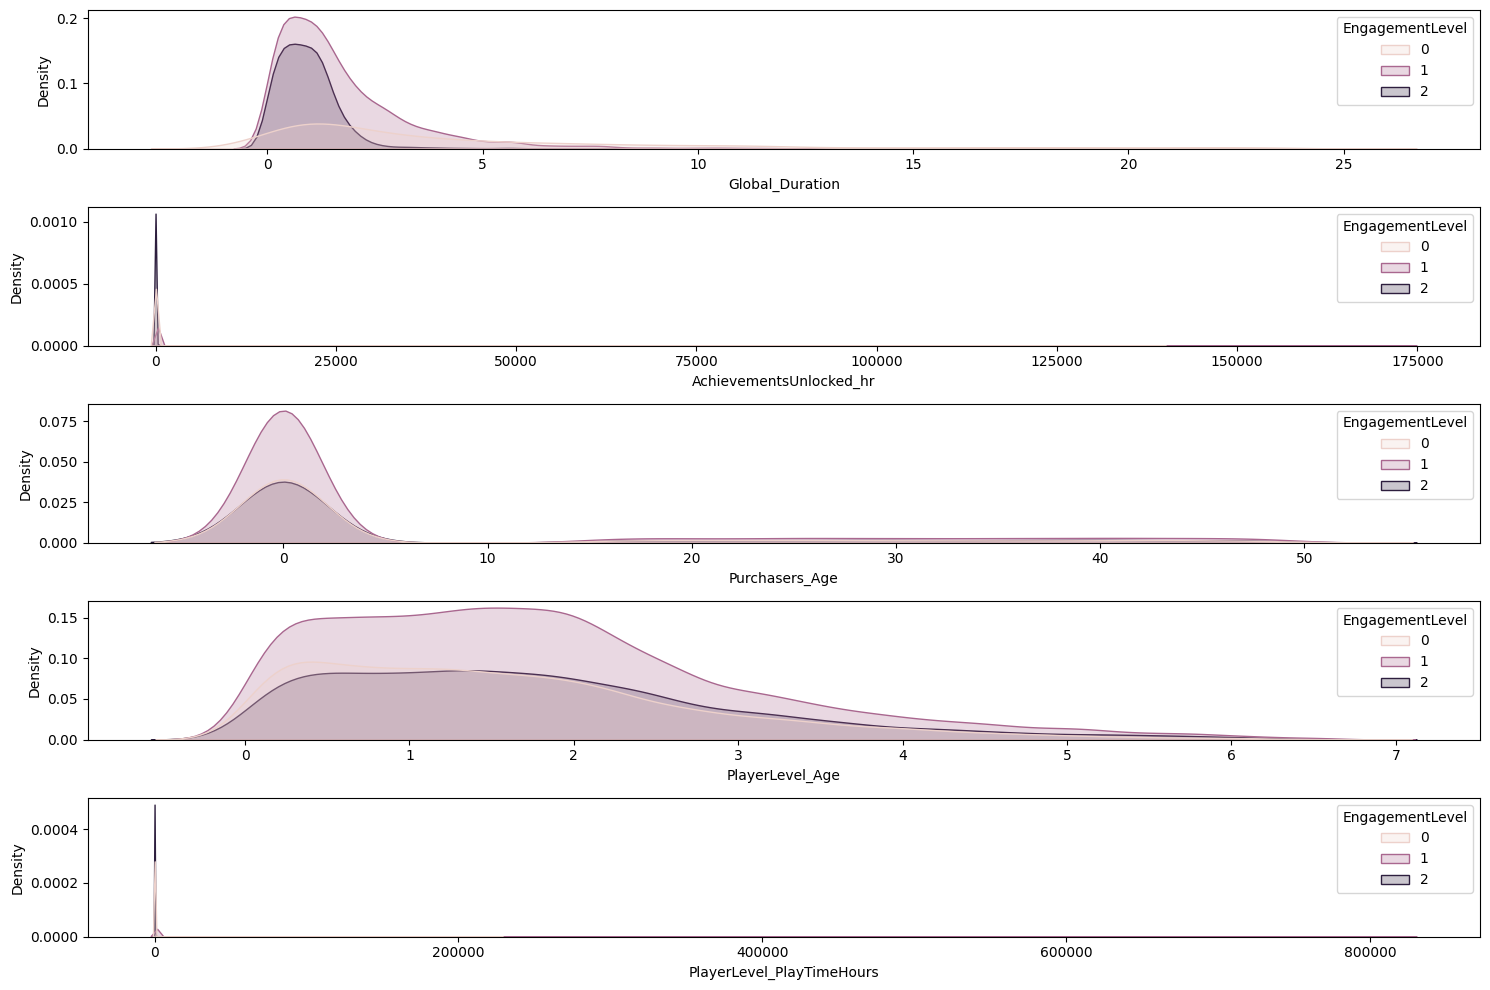

In [624]:
fig, axes = plt.subplots(5,1, figsize=(15,10))
axes = axes.flatten()

columns = ['Global_Duration', 'AchievementsUnlocked_hr','Purchasers_Age', 'PlayerLevel_Age',
       'PlayerLevel_PlayTimeHours']

for i,col in enumerate(columns):
    sns.kdeplot(data=preprocessed_data, x=col, hue='EngagementLevel', fill=True, ax=axes[i])
    
plt.tight_layout()
plt.show()

In [610]:
log_df = safe_log_transform(preprocessed_data[columns])
log_df['EngagementLevel'] = df['EngagementLevel']

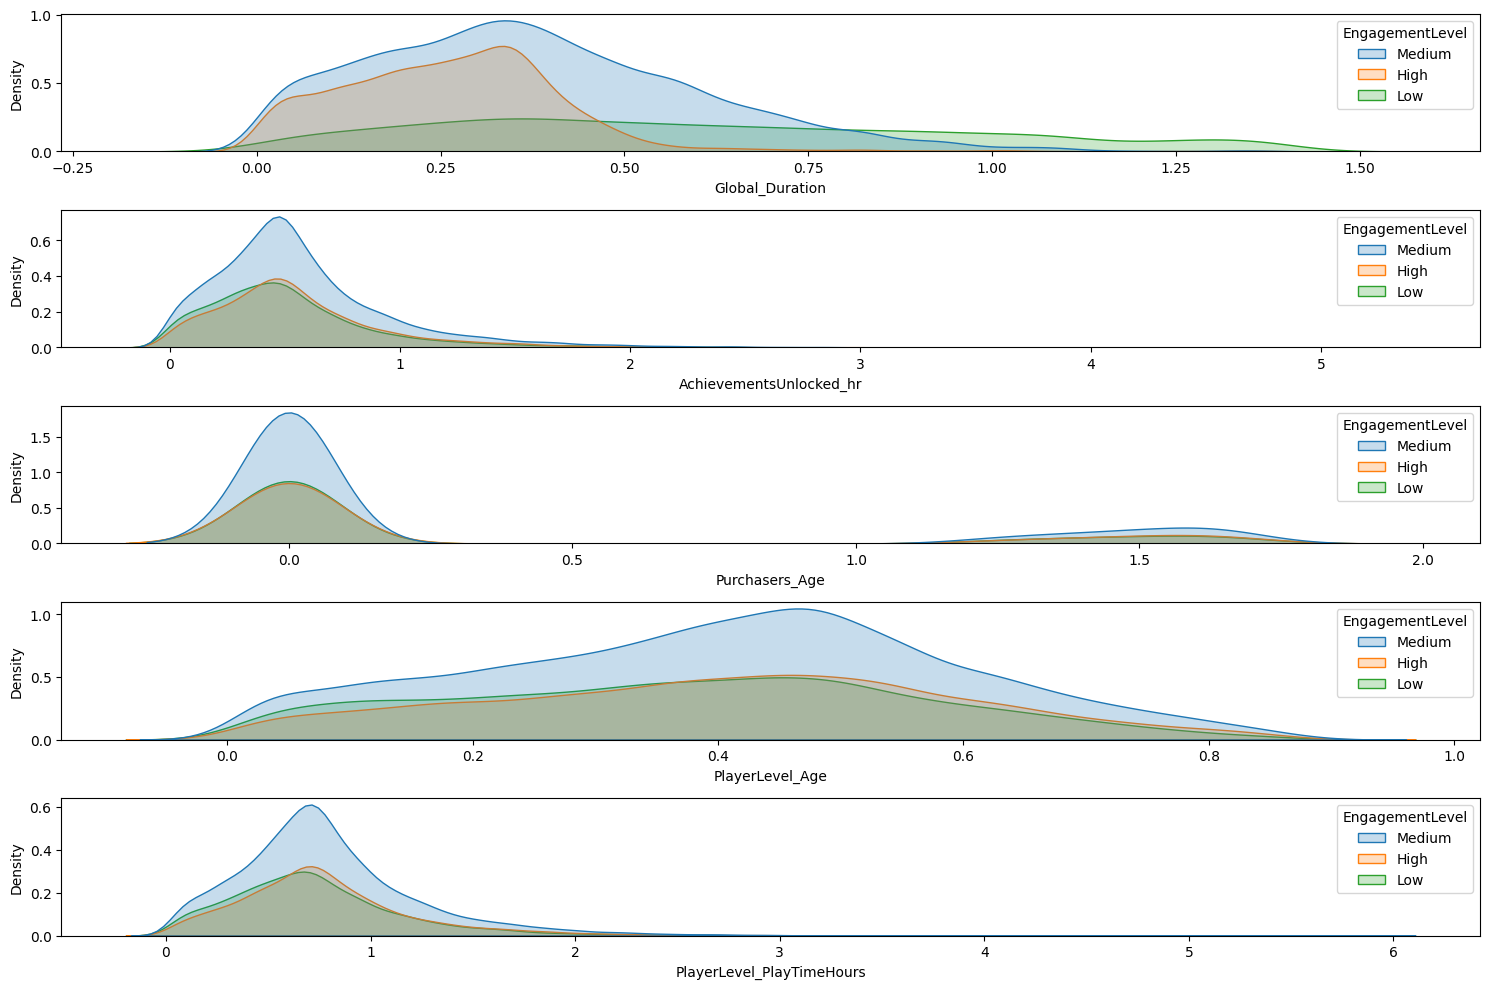

In [611]:
fig, axes = plt.subplots(5,1, figsize=(15,10))
axes = axes.flatten()

columns = ['Global_Duration', 'AchievementsUnlocked_hr','Purchasers_Age', 'PlayerLevel_Age',
       'PlayerLevel_PlayTimeHours']

for i,col in enumerate(columns):
    sns.kdeplot(data=log_df, x=col, hue='EngagementLevel', fill=True, ax=axes[i])
    
plt.tight_layout()
plt.show()

In [637]:
log_features_list = ['Age',
 'PlayTimeHours',
 'SessionsPerWeek',
 'AvgSessionDurationMinutes',
 'PlayerLevel',
 'AchievementsUnlocked',
 'Global_Duration', 
 'AchievementsUnlocked_hr',
 'Purchasers_Age', 
 'PlayerLevel_Age',
 'PlayerLevel_PlayTimeHours']

model_qa = ModelQA(preprocessed_data=pipeline.data, target_col='EngagementLevel', ID_col='PlayerID', log_features=None)
model = model_qa.run_model_pipeline()
model

INFO:root:--- Starting Model QA Pipeline ---


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/auroraleport/Desktop/MyGit/my_project_code/AuroraML/venv_3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/auroraleport/Desktop/MyGit/my_project_code/AuroraML/venv_3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/auroraleport/Desktop/MyGit/my_project_code/AuroraML/venv_3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function be


--- PERFORMANCE SUMMARY ---

Train Set:
  Avg Precision       : 0.9075
  Avg Recall          : 0.9075
  AUROC (weighted-ovo): 0.9548
  Avg F1 (Weighted)   : 0.9074

Test Set:
  Avg Precision       : 0.8943
  Avg Recall          : 0.8944
  AUROC (weighted-ovo): 0.9447
  Avg F1 (Weighted)   : 0.8943
---------------------------



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing_cat',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Location',
                                                   'GameGenre',
                                                   'GameDifficulty',
                                                   'PlayerLevel_bins']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-...
                                                   'Purchasers_Age',
                                                   'PlayerLevel_Age',
                                                   'PlayerLevel_PlayTimeHours']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['InGamePurchases'])])),
                ('smote_tomek',
                 SMOTETomek(random_state=42,
                            sampling_strategy={0: 19374, 1: 19374, 2: 19374})),
                ('GBC',
                 GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                            random_state=42, subsample=0.8))])

[CV] END GBC__max_depth=3, smote_tomek__sampling_strategy={0: 16000, 1: 19374, 2: 16000}; total time= 1.4min
[CV] END GBC__max_depth=3, smote_tomek__sampling_strategy={0: 19374, 1: 19374, 2: 19374}; total time= 1.8min
[CV] END GBC__max_depth=5, smote_tomek__sampling_strategy={0: 16000, 1: 19374, 2: 16000}; total time= 2.2min
[CV] END GBC__max_depth=3, smote_tomek__sampling_strategy={0: 16000, 1: 19374, 2: 16000}; total time= 1.4min
[CV] END GBC__max_depth=3, smote_tomek__sampling_strategy={0: 19374, 1: 19374, 2: 19374}; total time= 1.8min
[CV] END GBC__max_depth=5, smote_tomek__sampling_strategy={0: 16000, 1: 19374, 2: 16000}; total time= 2.2min
[CV] END GBC__max_depth=3, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.1min
[CV] END GBC__max_depth=3, smote_tomek__sampling_strategy={0: 16000, 1: 19374, 2: 16000}; total time= 1.5min
[CV] END GBC__max_depth=5, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.6min
[CV] END GBC__max_d

In [598]:
preprocessor = model.named_steps['preprocessor']
#preprocessor.get_feature_names_out()
pd.DataFrame(preprocessor.transform(preprocessed_data))

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.472096,0.075582,-0.016907,0.0,1.032213,0.663313,-0.213917,0.460767,0.838346,0.328731
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.472096,-1.102364,-0.018822,0.0,-0.134765,-0.654005,-0.409407,0.879034,-1.397738,-0.644603
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.472096,-0.123422,-0.017308,0.0,-0.944363,-0.185692,0.911336,0.858678,-0.102833,0.871377
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2.104249,-0.092992,-0.012917,1.0,0.420769,-0.709166,0.238408,0.113413,0.459304,1.022470
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.472096,0.917152,-0.016064,0.0,0.246607,0.604109,-1.288437,0.741366,1.053244,0.758130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.472096,0.737347,-0.017397,0.0,0.155645,0.967272,-0.640622,-0.067758,0.923589,-0.293657
40030,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.472096,-0.105059,-0.016647,0.0,1.100688,0.430261,1.117438,0.539301,0.714161,0.412585
40031,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.632052,0.153248,0.060589,1.0,-2.050137,-2.901717,0.359278,1.171303,-0.317731,-2.573557
40032,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2.030639,0.254641,-0.016815,1.0,0.334932,0.474092,-0.923606,0.707672,0.697676,-0.644603


In [606]:
y_pred = model.predict(preprocessed_data)
y_pred

array([1, 1, 2, ..., 2, 1, 1])

In [605]:
y_true = preprocessed_data['EngagementLevel']
y_true

0        1
1        1
2        2
3        1
4        1
        ..
40029    1
40030    2
40031    2
40032    1
40033    1
Name: EngagementLevel, Length: 40034, dtype: int64

In [ ]:
# def calculate_metrics(y_true: pd.Series, y_pred: np.ndarray) -> Dict[str, Any]:
#     """Calculates weighted Precision, Recall, and F1-Score for multi-class data."""
    
#     # Ensure both inputs are NumPy arrays for consistent computation
#     y_true_array = y_true.values if isinstance(y_true, pd.Series) else y_true
    
#     # Use 'weighted' average for multi-class imbalanced data
#     try:
#         avg_precision = precision_score(y_true_array, y_pred, average='weighted', zero_division=0)
#         avg_recall = recall_score(y_true_array, y_pred, average='weighted', zero_division=0)
#         avg_f1 = f1_score(y_true_array, y_pred, average='weighted', zero_division=0)
#     except ValueError as e:
#         print(f"Error calculating metrics: {e}. Check if y_true and y_pred have same class labels.")
#         return {"Error": "Metric calculation failed"}

#     results = {
#         'Avg Precision (Weighted)': f"{avg_precision:.4f}",
#         'Avg Recall (Weighted)': f"{avg_recall:.4f}",
#         'Avg F1 (Weighted)': f"{avg_f1:.4f}",
#         'AUROC (weighted-ovo)': "N/A (Requires predict_proba)"
#     }
    
#     return results

In [ ]:
# calculate_metrics(y_true=y_true, y_pred=y_pred)

{'Avg Precision (Weighted)': '0.9053',
 'Avg Recall (Weighted)': '0.9050',
 'Avg F1 (Weighted)': '0.9046',
 'AUROC (weighted-ovo)': 'N/A (Requires predict_proba)'}